importamos las librerias:

In [245]:
# Tratamiento de datos
import time
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from scipy.spatial.distance import cosine
from unidecode import unidecode
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [246]:
# Gráficos
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from wordcloud import WordCloud

In [247]:
# Preprocesado y modelado
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

In [248]:
# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

lectura del archivo

In [249]:
# Ruta del archivo CSV en Google Drive
rt_reviews = "train_new.txt"

In [250]:
# Leer el archivo CSV en un DataFrame
df = pd.read_csv(rt_reviews, encoding='ISO-8859-1', sep="|")
df.columns = ["Language", "Text"]

In [251]:
# Verificar que los datos se hayan cargado correctamente

tratando el conjunto de datos

In [252]:
def limpiar_tokenizar(texto):
    # Crear instancia del lematizador
    lemmatizer = WordNetLemmatizer()

    nuevo_texto = texto.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex, ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Eliminación de diéresis
    nuevo_texto = unidecode(nuevo_texto)
    # Eliminación de fracciones
    nuevo_texto = re.sub("\d+/\d+", ' ', nuevo_texto)
    # Eliminación de fechas
    nuevo_texto = re.sub("\d{1,2}/\d{1,2}/\d{2,4}", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep=' ')
    # Lematización
    nuevo_texto = [lemmatizer.lemmatize(token) for token in nuevo_texto]
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return nuevo_texto

In [253]:
df['texto_tokenizado'] = df.apply(
    lambda x: limpiar_tokenizar(x[1]), axis=1)
df.to_csv(
    'resultadoTokeniz.csv', index=False)


textFinal = df.explode(column='texto_tokenizado')
textFinal = textFinal.drop(columns='Text')
textFinal = textFinal.rename(columns={'texto_tokenizado': 'token'})

groups = textFinal.groupby(textFinal.Language)
textFinalEn = groups.get_group("en")
textFinalNl = groups.get_group("nl")

textFinal.head(10)

,Language,token
0,en,and
0,en,africa
0,en,in
0,en,permission
0,en,winner
0,en,of
0,en,in
0,en,year
0,en,to
0,en,south


Visualizando datos

palabras mas repeditas:

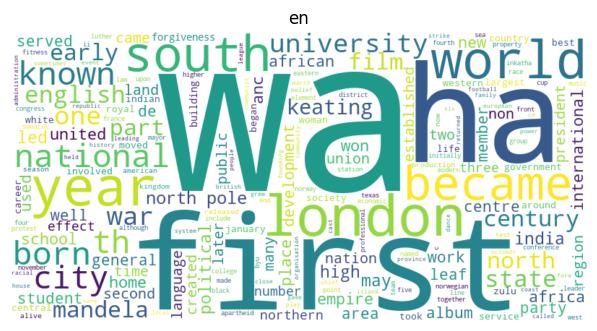

In [254]:
# Nube de palabras en ingles
# Import the required libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert float items to strings in the palabras list
palabras_por_categoria = textFinalEn.groupby('Language')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordcloudsEn = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(palabras))
    wordcloudsEn[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(12, 6))
for i, (categoria, wordcloud) in enumerate(wordcloudsEn.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()

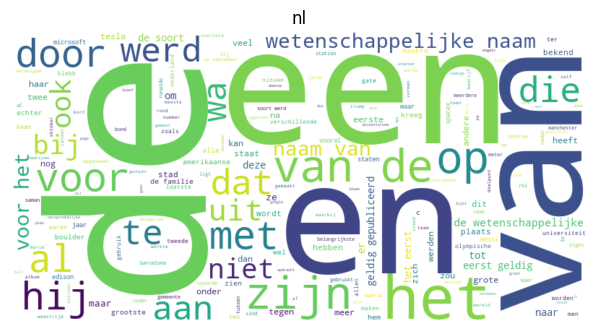

In [255]:
# Nube de palabras en holandes
# Import the required libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert float items to strings in the palabras list
palabras_por_categoria = textFinalNl.groupby('Language')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordcloudsEn = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(palabras))
    wordcloudsEn[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(12, 6))
for i, (categoria, wordcloud) in enumerate(wordcloudsEn.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()

cantidad total de palabras

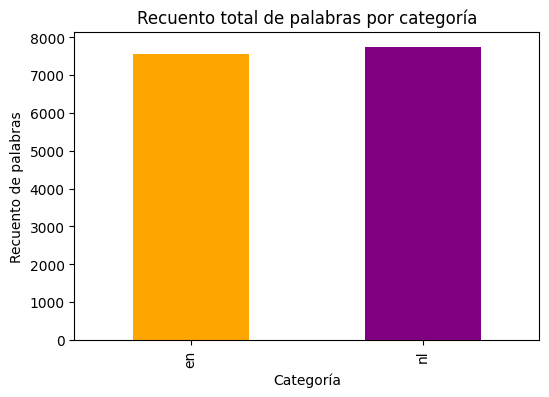

--------------------------
Palabras totales por categoría 👇
--------------------------


Language
en    7550
nl    7753
Name: token, dtype: int64

In [256]:
#@title Recuento total de palabras por categoría
word_count = textFinal.groupby('Language')['token'].count()

# Crear la tabla gráfica
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['orange', 'purple']  # Colores para las categorías 'rotten' y 'fresh'
word_count.plot(kind='bar', ax=ax, color=colors)
ax.set_xlabel('Categoría')
ax.set_ylabel('Recuento de palabras')
ax.set_title('Recuento total de palabras por categoría')

# Mostrar la tabla gráfica
plt.show()

print('--------------------------')
print('Palabras totales por categoría 👇')
print('--------------------------')
textFinal.groupby(by='Language')['token'].count()

Conteo de palabras distintas:

In [257]:
print('----------------------------')
print('Palabras distintas por categoria')
print('----------------------------')
textFinal.groupby(by='Language')['token'].nunique()

----------------------------
Palabras distintas por categoria
----------------------------


Language
en    2693
nl    2718
Name: token, dtype: int64

porcentaje de palabras distintas:

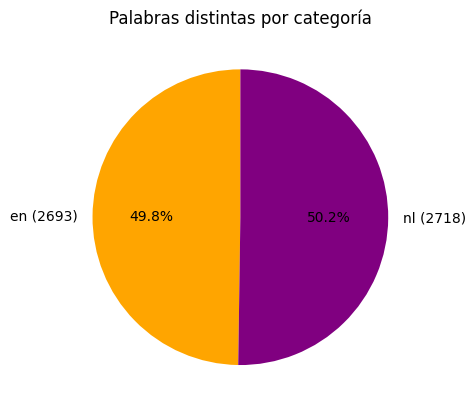

In [258]:
#@title Gráfico porcentaje de palabras distintas por categoría
unique_words = textFinal.groupby('Language')['token'].nunique()


# Crear el gráfico de pastel
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(unique_words, labels=unique_words.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Agregar los valores numéricos junto a las etiquetas
for i, label in enumerate(texts):
    percentage = label.get_text()
    count = unique_words[i]
    label.set_text(f'{percentage} ({count})')

ax.set_title('Palabras distintas por categoría')

# Mostrar el gráfico de pastel
plt.show()

palabras comunes entre categorias:

In [259]:
palabrasEn = set(textFinal[textFinal.Language == 'en']['token'])
palabrasNl = set(textFinal[textFinal.Language == 'nl']['token'])


print(f"Palabras comunes entre Ingles y Holandes: {len(palabrasEn.intersection(palabrasNl))}")

Palabras comunes entre Ingles y Holandes: 164


nube de palabras comunes Ingles y Holandes:

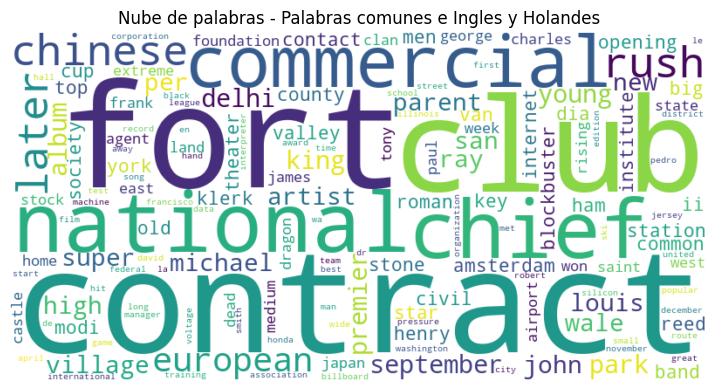

In [260]:
palabras_comunes = palabrasEn.intersection(palabrasNl)
palabras_comunes_lista = list(palabras_comunes)

df_palabras_comunes = pd.DataFrame(palabras_comunes_lista, columns=['Palabra'])
df_palabras_comunes.to_csv('palabras_comunes.csv', index=False)
#@title Nube las palabras comunes en las dos categorias
# Convertir los elementos de palabras_comunes a cadenas de texto
palabras_comunes_str = [str(palabra) for palabra in palabras_comunes]

# Crear una cadena de texto con las palabras comunes
texto_comun = ' '.join(palabras_comunes_str)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_comun)

# Mostrar la nube de palabras
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Palabras comunes e Ingles y Holandes')
plt.show()

Comparacion en el uso de palabras: 
Se calcula el log odds ratio de cada palabra en los comentarios y determina si una palabra es más frecuente en la categoría ingles o holandes. Luego, muestra las 10 palabras más diferenciadoras en función del valor absoluto del log odds.

En el DataFrame mostrado, representan lo siguiente:

rotte & fresh: La probabilidad estimada de que la palabra aparezca en la categoría ingles o holandes

log_odds: El logaritmo de la razón de probabilidades (log odds ratio) de la palabra entre las categorías "ingles" y "holandes".

abs_log_odds: Este valor representa la magnitud de la diferencia en la probabilidad de la palabra entre las categorías.

categoria frecuente: La categoría en la que la palabra es más frecuente según el log odds ratio. "ingles" indica que la palabra es más frecuente en la categoría "ingles", y "holandes" indica que es más frecuente en la categoría "holandes".

Los valores positivos indican una asociación más fuerte con la categoría "holandes", mientras que los valores negativos indican una asociación más fuerte con la categoría "ingles".

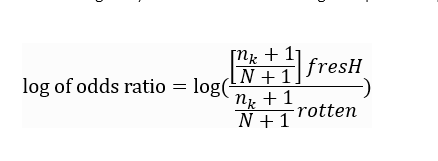

Una forma de hacer este análisis es mediante el log of odds ratio de las frecuencias. Esta comparación se hace por pares, en este caso se comparan Ingles y Holandes.

siendo nk el número de veces que aparece el término k en los textos de cada categoria y N el número total de términos de cada usuario.

calculo de la probabilidad de cada palabra

In [261]:
# Cálculo del log of odds ratio de cada palabra (en vs nl)

# Pivotaje y despivotaje
comentarios_pivot = textFinal.groupby(["Language","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="Language", values= "count")

comentarios_pivot = comentarios_pivot.fillna(value=0)
comentarios_pivot.columns.name = None

comentarios_unpivot = comentarios_pivot.melt(value_name='n', var_name='Language', ignore_index=False)
comentarios_unpivot = comentarios_unpivot.reset_index()

# Selección de las categorias en y nl
comentarios_unpivot = comentarios_unpivot[comentarios_unpivot.Language.isin(['en', 'nl'])]

# Se añade el total de palabras de cada categoria
comentarios_unpivot = comentarios_unpivot.merge(
                    textFinal.groupby('Language')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'Language'
                 )

# Cálculo de odds y log of odds de cada palabra
comentarios_logOdds = comentarios_unpivot.copy()
comentarios_logOdds['odds'] = (comentarios_logOdds.n + 1) / (comentarios_logOdds.N + 1)
comentarios_logOdds = comentarios_logOdds[['token', 'Language', 'odds']] \
                    .pivot(index='token', columns='Language', values='odds')
comentarios_logOdds.columns.name = None

comentarios_logOdds['log_odds']     = np.log(comentarios_logOdds.en/comentarios_logOdds.nl)
comentarios_logOdds['abs_log_odds'] = np.abs(comentarios_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de en. Esto es así porque el ratio se ha
# calculado como en/nl.

comentarios_logOdds['categoria frecuente'] = np.where(comentarios_logOdds.log_odds > 0,
                                              "nl",
                                              "en"
                                    )

Permite identificar las palabras que tienen una mayor probabilidad de pertenecer a una categoría en comparación con la otra.

In [262]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
comentarios_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,en,nl,log_odds,abs_log_odds,categoria frecuente
token,,,,,
het,0.000132,0.031081,-5.458268,5.458268,en
een,0.000132,0.028115,-5.357966,5.357966,en
van,0.000265,0.039721,-5.010424,5.010424,en
to,0.018276,0.000129,4.953783,4.953783,nl
voor,0.000132,0.013283,-4.608200,4.608200,en
en,0.000265,0.026309,-4.598444,4.598444,en
op,0.000132,0.012252,-4.527348,4.527348,en
and,0.034830,0.000387,4.500071,4.500071,nl
zijn,0.000132,0.011865,-4.495260,4.495260,en


top 15 palabras mas representativas:

Text(0.5, 0, 'log odds ratio (ingles / holandes)')

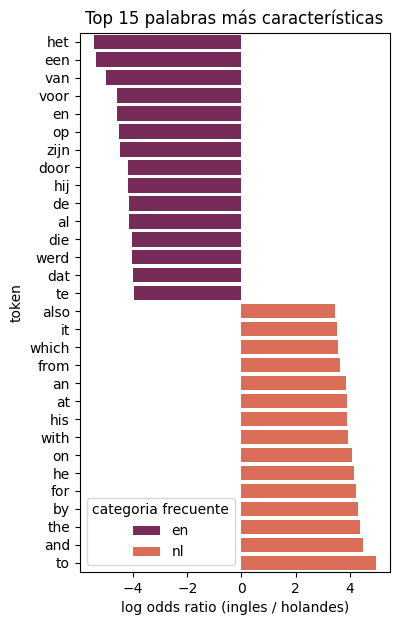

In [263]:
top_30 = comentarios_logOdds[['log_odds', 'abs_log_odds', 'categoria frecuente']] \
        .groupby('categoria frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x='log_odds',
    y='token',
    hue='categoria frecuente',
    data=top_30,
    ax=ax,
    palette="rocket"
)
ax.set_title('Top 15 palabras más características')
ax.set_xlabel('log odds ratio (ingles / holandes)')

Frecuencia de las palabras
Permite calcular la frecuencia relativa de cada término en el texto mediante el cálculo del Term Frequency (tf).

In [264]:
tf = textFinal.copy()
# Número de veces que aparece cada término en cada comentario
tf = tf.groupby(["token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por comentario
tf['total_count'] = tf.groupby('token')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(5)

,token,count,total_count,tf
0,-achterstand,1,1,1.0
3501,plaatsnaamtoevoeging,1,1,1.0
3500,plaatselijke,1,1,1.0
3499,plaats,10,10,1.0
3498,pizzabodems,1,1,1.0


Se calcula el IDF para cada término en el conjunto de texto, lo cual es útil para determinar la importancia relativa de cada término.

In [265]:
idf = textFinal.copy()
total_documents = idf["token"].drop_duplicates().count()
# Número de comentarios en los que aparece cada término
idf = idf.groupby(["token"])["token"].agg(["count"]).reset_index()
idf[' n_comentarios'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf[' n_comentarios'])
idf = idf[["token"," n_comentarios", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_comentarios,idf
4493,the,622,2.132472
1077,de,597,2.173495
2168,in,506,2.338875


En esta tabla podemos observa el número de comentaroosn_comentarios" refleja el número de comentarios en los que aparece cada término.

Term Frequency - Inverse Document Frequency:

La razón principal para realizar este cálculo es identificar los términos más relevantes y distintivos en un conjunto de documentos.

Creación de la matriz tf-idf

In [266]:
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="token").head()

,token,count,total_count,tf,n_comentarios,idf,tf_idf
0,-achterstand,1,1,1.0,1,8.565412,8.565412
1,-overwinning,2,2,1.0,2,7.872265,7.872265
2,-page,1,1,1.0,1,8.565412,8.565412
3,-positie,1,1,1.0,1,8.565412,8.565412
4,-shirts,1,1,1.0,1,8.565412,8.565412


Creacion de los conjuntos de datos:

In [267]:
ruta_archivo = r'./resultadoTokeniz.csv'

# Leer el archivo CSV
df = pd.read_csv(ruta_archivo, nrows=100000)

# Acceder a los datos de las columnas
Language = df['Language']
Text = df['Text']
texto_tokenizado = df['texto_tokenizado']

df.head()

,Language,Text,texto_tokenizado
0,en,"and Africa in permission winners,[25] of in ye...","['and', 'africa', 'in', 'permission', 'winner'..."
1,en,President tournament wearing presenting were m...,"['president', 'tournament', 'wearing', 'presen..."
2,en,The the are 'The thirty-eight reference as Ell...,"['the', 'the', 'are', 'the', 'thirty-eight', '..."
3,en,a The Rugby In and Warrant head 'The Webb and ...,"['the', 'rugby', 'in', 'and', 'warrant', 'head..."
4,en,an high - The game engraved Crown Football two...,"['an', 'high', 'the', 'game', 'engraved', 'cro..."


In [268]:
datos_X = df['texto_tokenizado']
datos_y = df['Language']

print(datos_X.unique())
print(datos_y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size=0.80,
    random_state=42
)

#con 80% para prueba 71%
#con 33% test da  75%

["['and', 'africa', 'in', 'permission', 'winner', 'of', 'in', 'year', 'to', 'south', 'after', 'match', 'of', 'test']"
 "['president', 'tournament', 'wearing', 'presenting', 'were', 'met', 'africa', 'series', 'the', 'resumption', 'rugby', 'the', 'opening', 'match']"
 "['the', 'the', 'are', 'the', 'thirty-eight', 'reference', 'elli', 'garrard', 'in', 'to', 'fellow', 'referred', 'after', 'cup']"
 ...
 "['uiteindelijk', 'te', 'in', 'tot', 'individuele', 'zomerspelen', 'al', 'maar', 'beste', 'olympische', 'degen', 'koos', 'spelen', 'een']"
 "['degen', 'van', 'olympische', 'en', 'deze', 'van', 'schermen', 'de', 'zilveren', 'sportieve', 'olympische', 'zou', 'individuele', 'uitzondering', 'zijn']"
 "['alle', 'het', 'roeier', 'op', 'zomerspelen', 'zijn', 'berlijn', 'edities', 'in', 'het', 'zowel', 'van', 'uiteindelijk']"]
['en' 'nl']


Vectorizacion

In [269]:
# Crear una instancia del vectorizador
vectorizer = CountVectorizer()

# Ajustar el vectorizador con los datos de entrenamiento
Xtrain = vectorizer.fit_transform(X_train)

# Transformar los datos de prueba utilizando el vectorizador ajustado
Xtest = vectorizer.transform(X_test)

print(Xtrain.shape)

(213, 1544)


In [270]:
tokens = vectorizer.get_feature_names_out()
print("Tokens:", tokens)

print("Tokens:", len(tokens))

Tokens: ['aan' 'aandelen' 'aangrenzende' ... 'zwart' 'zwelethini' 'zwitserse']
Tokens: 1544


In [271]:
print("Conjunto de entrenamiento - Características:", Xtrain.shape)
print("Conjunto de entrenamiento - Etiquetas:", y_train.shape)
print("Conjunto de prueba - Características:", Xtest.shape)
print("Conjunto de prueba - Etiquetas:", y_test.shape)

Conjunto de entrenamiento - Características: (213, 1544)
Conjunto de entrenamiento - Etiquetas: (213,)
Conjunto de prueba - Características: (855, 1544)
Conjunto de prueba - Etiquetas: (855,)


Funcion de seleccion de caracteristicas

In [272]:
def cuasiConstantes(Xtrain, Xtest, threshold=0.02):
    # Crear el objeto VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)

    # Aplicar la eliminación de características cuasi-constantes en la matriz tf-idf de entrenamiento
    xtrain = selector.fit_transform(Xtrain)

    # Obtener los índices de las características seleccionadas
    selected_feature_indices = selector.get_support(indices=True)

    # Filtrar la matriz tf-idf de prueba utilizando los índices de características seleccionadas
    xtest = selector.transform(Xtest)

    num_selected_features = xtrain.shape[1]
    print("Número de características seleccionadas:", num_selected_features)

    return xtrain, xtest, selected_feature_indices


def ScaracteristicasRandom(xtrain, y_train, n_estimators=100, max_depth=None, min_samples_split=2):
    # Crear un estimador Random Forest con parámetros ajustados
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, n_jobs=-1)

    # Crear un selector RFE con Random Forest y ranking
    rfe = RFE(estimator=rf, step=2)

    # Aplicar RFE al conjunto de datos
    xtrainE = rfe.fit_transform(xtrain, y_train)
    # Obtener las características seleccionadas
    selected_features = rfe.support_

    # Obtener el ranking de importancia de características
    feature_ranking = rfe.ranking_
# Imprimir las características seleccionadas
    print("Características seleccionadas:")
    for i, feature in enumerate(selected_features):
        if feature:
            print(f"Feature {i+1}")

    # Imprimir el ranking de características
    print("Ranking de características :")
    for i, rank in enumerate(feature_ranking):
        print(f"Feature {i+1}: {rank}")
        


    return xtrainE, selected_features, feature_ranking

In [273]:
from sklearn.feature_selection import VarianceThreshold
xtrain, xtest, selected_feature_indices=cuasiConstantes(Xtrain, Xtest)
#num_selected_features = xtrain.shape[1]

Número de características seleccionadas: 80


In [274]:
xtrainE, selected_features, feature_ranking = ScaracteristicasRandom(xtrain, y_train)
xtestE = xtest[:, selected_features]  # Conjunto de prueba transformado

Características seleccionadas:
Feature 1
Feature 3
Feature 5
Feature 7
Feature 9
Feature 10
Feature 12
Feature 14
Feature 15
Feature 16
Feature 17
Feature 20
Feature 21
Feature 23
Feature 24
Feature 34
Feature 35
Feature 36
Feature 38
Feature 39
Feature 40
Feature 43
Feature 44
Feature 46
Feature 47
Feature 49
Feature 52
Feature 54
Feature 60
Feature 63
Feature 65
Feature 66
Feature 67
Feature 69
Feature 71
Feature 72
Feature 73
Feature 74
Feature 77
Feature 78
Ranking de características :
Feature 1: 1
Feature 2: 21
Feature 3: 1
Feature 4: 12
Feature 5: 1
Feature 6: 9
Feature 7: 1
Feature 8: 7
Feature 9: 1
Feature 10: 1
Feature 11: 14
Feature 12: 1
Feature 13: 11
Feature 14: 1
Feature 15: 1
Feature 16: 1
Feature 17: 1
Feature 18: 3
Feature 19: 15
Feature 20: 1
Feature 21: 1
Feature 22: 17
Feature 23: 1
Feature 24: 1
Feature 25: 14
Feature 26: 13
Feature 27: 2
Feature 28: 16
Feature 29: 3
Feature 30: 17
Feature 31: 19
Feature 32: 20
Feature 33: 16
Feature 34: 1
Feature 35: 1
Feature 36:

In [275]:
num_selected_features = sum(selected_features)
print("Número de características seleccionadas:", num_selected_features)

Número de características seleccionadas: 40


Modelos de aprendizaje de máquina 🤖
A patir de de este bloque de código se inicia con la implementación de los modelos:

Random Forest
Árboles de decisión
Redes neuronales
Redes neuronales profundas
En cada método hacemos una prueba sin selección de carácteristica, usando Feature cuasi-Contantes y Random forest FRE.

Random forest

creando instancia de random forest

In [276]:
rf_Model = RandomForestClassifier()

creando funcion de entrenamiento de bosque random

In [286]:
def RandomForestFit(x,y,params):
    rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = params, cv = 2, verbose=2, n_jobs = 4)
    rf_Grid.fit(x, y)
    return rf_Grid

Pruebas para random forest con parámetros por defecto

estableciendo parametros (por defecto):

In [304]:
param_grid = {'n_estimators': [100],
               'max_features': ['sqrt'],
               'max_depth': [None],
               'min_samples_split': [2],
               'min_samples_leaf': [1],
               "random_state":[None]       
                }
print(param_grid)

{'n_estimators': [100], 'max_features': ['sqrt'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'random_state': [None]}


Descripción de parámetros:

n_estimators: Representa el número de árboles de decisión que se van a utilizar en el modelo.

start: Es el valor de inicio para la secuencia de números generada.

stop: Es el valor final de la secuencia de números generada.

num: Es el número de valores que se generarán en la secuencia.

entrenando:

In [305]:
rf_Grid = RandomForestFit(xtrain,y_train,param_grid)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


analizando resultados:

In [306]:
rf_Grid.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': None}

In [309]:
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 98.480%


Prueba con Hiperámetros y feature cuasi-constante

estableciendo parametros:

In [280]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start=150, stop=400, num=4)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [2, 4],
               'min_samples_split': [5, 10],
               'min_samples_leaf': [1, 2],
               "random_state":[42]       
                }
print(param_grid)

{'n_estimators': [150, 233, 316, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [5, 10], 'min_samples_leaf': [1, 2], 'random_state': [42]}


entrenando:

In [287]:
rf_Grid = RandomForestFit(xtrain,y_train,param_grid)

Fitting 2 folds for each of 64 candidates, totalling 128 fits


analizando resultados:

In [288]:
rf_Grid.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 316,
 'random_state': 42}

In [ ]:
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 98.830%


Prueba con selección de caracteristicas Random FRE

estableciendo parametros:

In [296]:
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=150, num=3)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    "random_state":[42,42]    
}

print(param_grid)

{'n_estimators': [100, 125, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'random_state': [42, 42]}


entrenando:

In [292]:
rf_Grid = RandomForestFit(xtrainE,y_train,param_grid)

Fitting 2 folds for each of 64 candidates, totalling 128 fits


analizando resultados:

In [293]:
rf_Grid.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400,
 'random_state': 42}

In [294]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrainE, y_train) * 100
test_accuracy = rf_Grid.score(xtestE, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 99.531%
Precisión de prueba: 98.246%


prueba adicional
A continuación se realizan tres pruebas con diferentes hiperparámetros para revisar la precisión en cada prueba y lograr mejores resultados que la prueba inicial.

estableciendo los parametros de los modelos:

In [ ]:
param_sets = [
    {
        "fit":{
            "x":xtrainE,
            "y":y_train
        },
        "test":{
            "x":xtrainE,
            "y":y_train
        },
        "params":{
            'n_estimators': [int(x) for x in np.linspace(start=100, stop=150, num=3)],
            'max_features': ['auto', 'sqrt'],
            'max_depth': [2, 4],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            "random_state":[42,42]   
        } 
    },
    {
        "fit":{
            "x":xtrainE,
            "y":y_train
        },
        "test":{
            "x":xtrainE,
            "y":y_train
        },
        "params":{
            'n_estimators': [100],
            'max_features': ['sqrt'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            "random_state":[None]       
        }
    },
    {
        "fit":{
            "x":xtrainE,
            "y":y_train
        },
        "test":{
            "x":xtrainE,
            "y":y_train
        },
        "params":{
            'n_estimators': [int(x) for x in np.linspace(start=100, stop=150, num=3)],
            'max_features': ['auto', 'sqrt'],
            'max_depth': [2, 4],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            "random_state":[42,42]   
        } 
    },
]


ejecutando los modelos:

In [326]:
for i, params in enumerate(param_sets):
    start_time = time.time()  # Registrar el tiempo de inicio
    
    # Crear una instancia del modelo RandomForestClassifier
    rf_Grid = RandomForestFit(params["fit"]["x"],params["fit"]["y"],params["params"])
    
    # Entrenar el modelo con los parámetros actuales

    bestParams=rf_Grid.best_params_
    
    train_accuracy = rf_Grid.score(params["fit"]["x"], params["fit"]["y"]) * 100
    test_accuracy = rf_Grid.score(params["test"]["x"],params["test"]["y"]) * 100
    
    end_time = time.time()  # Registrar el tiempo de finalización
    elapsed_time = end_time - start_time  # Calcular el tiempo transcurrido

    # Redondear el tiempo transcurrido a dos decimales
    elapsed_time = round(elapsed_time, 2)
    
    # Imprimir los resultados con el número de prueba, tiempo de ejecución y precisión en %
    print("Número de prueba: ", i+1)
    print("Parámetros: ", params["params"])
    print("Precisión de entrenamiento: ", "{:.2f}%".format(train_accuracy))
    print("Precisión de prueba: ", "{:.2f}%".format(test_accuracy))
    print("mejores parametros: ", bestParams)
    print("Tiempo de ejecución : ", elapsed_time, "segundos")
    print("--------------------------------------")

Fitting 2 folds for each of 96 candidates, totalling 192 fits
Número de prueba:  1
Parámetros:  {'n_estimators': [100, 125, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'random_state': [42, 42]}
Precisión de entrenamiento:  99.53%
Precisión de prueba:  99.53%
mejores parametros:  {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
Tiempo de ejecución :  9.91 segundos
--------------------------------------
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Número de prueba:  2
Parámetros:  {'n_estimators': [100], 'max_features': ['sqrt'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'random_state': [None]}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  100.00%
mejores parametros:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'r

Árboles de decisión 🌳
Pruebas con parámetros por defecto.

In [ ]:
# Ajuste inicial del modelo
dt = DecisionTreeClassifier()
dt.fit(Xtrain, y_train)
y_pred_initial = dt.predict(Xtest)

# Matriz de confusión inicial
dt_initial = confusion_matrix(y_test, y_pred_initial)
dt_df_initial = pd.DataFrame(dt_initial)

# Precisión inicial
from sklearn.metrics import accuracy_score

dt_precision_initial = 100 * accuracy_score(y_test, y_pred_initial)
print('Precisión inicial: {0:.3f}%'.format(dt_precision_initial))

Precisión inicial: 96.959%


In [ ]:
# Generate a synthetic classification dataset

y_pred_train = dt.predict(Xtrain)
y_pred_test  = dt.predict(Xtest)

print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       105
          nl       1.00      1.00      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.96      0.98      0.97       428
          nl       0.98      0.96      0.97       427

    accuracy                           0.97       855
   macro avg       0.97      0.97      0.97       855
weighted avg       0.97      0.97      0.97       855



Prueba con los resultados de Features cuasi-constante

In [ ]:
model = DecisionTreeClassifier(
    criterion='gini',max_depth=10,splitter='best'
)

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2,4, 8, 10],
    'min_samples_leaf': [4, 2, 15],
    'max_features': [10,10,10]
}

grid_model_dt = GridSearchCV(
    estimator=model,
    param_grid = param_grid, 
    error_score="raise",
    refit=True,
    n_jobs=-1,
    cv=5,
)

In [ ]:

grid_model_dt.fit(xtrain, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(max_depth=10), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'max_features': [10, 10, 10],
                         'min_samples_leaf': [4, 2, 15],
                         'min_samples_split': [2, 4, 8, 10]})

In [ ]:
grid_model_dt.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [ ]:
grid_model_dt.best_score_

0.9858250276854928

In [ ]:
y_pred_train = grid_model_dt.predict(xtrain)
y_pred_test  = grid_model_dt.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       0.92      1.00      0.96       105
          nl       1.00      0.92      0.96       108

    accuracy                           0.96       213
   macro avg       0.96      0.96      0.96       213
weighted avg       0.96      0.96      0.96       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.89      1.00      0.94       428
          nl       1.00      0.87      0.93       427

    accuracy                           0.93       855
   macro avg       0.94      0.93      0.93       855
weighted avg       0.94      0.93      0.93       855



Selección de caracteristicas cuasi-constates y Random FRE

In [ ]:
grid_model_dt.fit(xtrainE, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(max_depth=10), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'max_features': [10, 10, 10],
                         'min_samples_leaf': [4, 2, 15],
                         'min_samples_split': [2, 4, 8, 10]})

In [ ]:
y_pred_train = grid_model_dt.predict(xtrainE)
y_pred_test  = grid_model_dt.predict(xtestE)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       0.95      1.00      0.98       105
          nl       1.00      0.95      0.98       108

    accuracy                           0.98       213
   macro avg       0.98      0.98      0.98       213
weighted avg       0.98      0.98      0.98       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.93      1.00      0.96       428
          nl       0.99      0.92      0.96       427

    accuracy                           0.96       855
   macro avg       0.96      0.96      0.96       855
weighted avg       0.96      0.96      0.96       855

